In [1]:
import sys
# sys.path
import ee
import pprint
from IPython.display import Image
# from image import Image as local_model
import openet.ssebop as local_model

In [2]:
# ! --NotebookApp.iopub_data_rate_limit 2000000.0
# ! NotebookApp.iopub_data_rate_limitFloat 2000000.0
# !conda config --NotebookApp.iopub_data_rate_limit 2000000.0
# !jupyter notebook --NotebookApp.iopub_data_rate_limit 2000000.0

In [3]:
try:
    ee.Initialize(use_cloud_api=True)
    print('worked')
except ee.EEException:
    ee.Authenticate()
    ee.Initialize(use_cloud_api=True)

worked


In [4]:
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
image_size = 768

In [5]:
ls_type = 'LE07'   # 'LC08', 'LE07' 
# DONE =====
# landsat_id = 'LE07_016034_20150120' # Richmond, VA Winter
# landsat_id = 'LC08_016034_20150213' # Richmond, VA Winter LS 8
# landsat_id = 'LC08_016034_20150707' # Richmond, VA Summer
# ==running==

# TODO =====

# landsat_id = 'LC08_021033_20150115' # Indianapolis, IN, Winter
# landsat_id = 'LE07_021033_20150718' # Indianapolis, IN, Summer
# landsat_id = 'LE07_028041_20150124' # RGValley, TX, Winter
# landsat_id = 'LE07_028041_20150703' # RGValley, TX, Summer
# landsat_id = 'LE07_032038_20150104' # West TX Winter
# landsat_id = 'LC08_032038_20150707' # West TX Summer
# landsat_id = 'LC08_019036_20150117' # Alpharreta GA, Winter
# landsat_id = 'LC08_019036_20150712' # Alpharreta GA, Summer

# landsat_id = 'LC08_042030_20150704' # Western Idaho Summer
# landsat_id = 'LC08_042030_20150102' # Western Idaho Winter
# landsat_id = 'LE07_043035_20150101' # Salinas Ca, Winter
# landsat_id = 'LE07_043035_20150712' # Salinas Ca, Summer

In [6]:
landsat_img = ee.Image('LANDSAT/' + ls_type + '/C01/T1_TOA/'+landsat_id) #LANDSAT/LC08/C01/T1_TOA

landsat_crs = landsat_img.select('B3').projection().getInfo()['crs']
landsat_region = landsat_img.geometry().bounds(1, 'EPSG:4326')
landsat_dt = ee.Date(landsat_img.get('system:time_start'))

In [7]:
# Build the SSEBop object from the Landsat image
model_obj = local_model.Image.from_landsat_c1_toa(
    landsat_img,
    et_reference_source='IDAHO_EPSCOR/GRIDMET', 
    et_reference_band='etr', 
    et_reference_factor=0.85,
    et_reference_resample='nearest',
    tcorr_source='GRIDDED',
)

Hello World!


In [8]:
ndvi_image = model_obj.ndvi
print(ndvi_image.getInfo())

{'type': 'Image', 'bands': [{'id': 'ndvi', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -1, 'max': 1}, 'dimensions': [8101, 7091], 'crs': 'EPSG:32613', 'crs_transform': [30, 0, 359985, 0, -30, 3618615]}], 'id': 'LANDSAT/LE07/C01/T1_TOA/LE07_032038_20150104', 'properties': {'system:time_start': 1420392722960, 'image_id': 'LANDSAT/LE07/C01/T1_TOA/LE07_032038_20150104', 'system:index': 'LE07_032038_20150104'}}


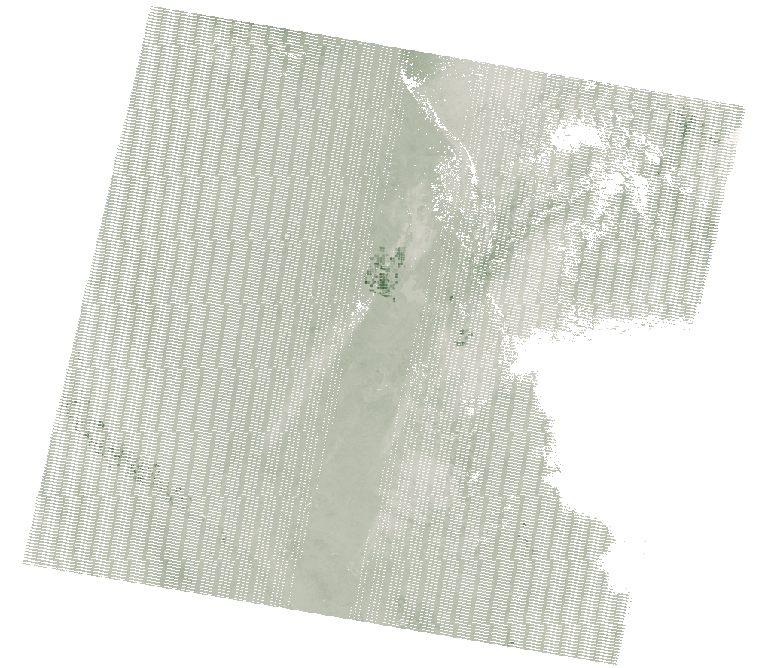

In [9]:
# # this might work for ndvi but not for higher processing images like SSEBop
image_url = model_obj.ndvi\
    .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ndvi_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

In [10]:
tcorr_image = model_obj.tcorr_gridded
# print('get image tcorr ', tcorr_image.getInfo())
# image_url = tcorr_image\
#     .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ndvi_palette, 
#                   'region': landsat_region, 'dimensions': image_size})
# print('image url \n', image_url)


In [11]:
def ee_task_start(task, n=10):
    """Make an exponential backoff Earth Engine request"""
    output = None
    for i in range(1, n):
        try:
            task.start()
            break
        except Exception as e:
            time.sleep(i ** 2)
    return task

In [12]:
# try to export and see if the image looks like expected.
task = ee.batch.Export.image.toAsset(image=tcorr_image, description='Tcorr10x10_finalsmooth_'+landsat_id, assetId='users/gbrlparrish/gridc_march/Tcorr10x10_finalsmooth_'+landsat_id, region=landsat_region)
# start the task
print('starting')
ee_task_start(task=task)
print('task submitted')

starting
task submitted


In [13]:
# EToF = model_obj.et_fraction
# print(EToF.getInfo())

In [14]:
# task = ee.batch.Export.image.toAsset(image=EToF, description='ETf_10x10_finalsmooth_' + landsat_id, assetId='users/gbrlparrish/gridc_march/ETf_10x10_finalsmooth_'+landsat_id, region=landsat_region)
# # start the task
# print('starting')
# ee_task_start(task=task)
# print('task submitted')